In [114]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec
import mpmath as mp
import sys
import os

def get_final_coefficients(param_sets, n_max=20, n_steps=10, b=3, d=2, use_mpmath=False, mp_dps=50):
    """
    Calculate the final coefficients for multiple parameter sets
    
    Args:
        param_sets: List of (J1, J2, M) parameter sets
        n_max: Maximum Fourier mode
        n_steps: Number of RG steps
        b: Length rescaling factor
        d: Dimension
        use_mpmath: If True, use mpmath high precision, otherwise use numpy (default: False)
        mp_dps: Decimal places of precision for mpmath when use_mpmath=True (default: 50)
        
    Returns:
        list: List of final coefficient matrices
    """
    final_coefficients = []
    
    # Import RG flow calculation functions based on chosen method
    if use_mpmath:
        # Set mpmath precision
        import mpmath as mp
        mp.dps = mp_dps
        print(f"Using mpmath for calculations with {mp_dps} decimal places of precision")
        
        try:
            # Try to import from lib directory
            sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
            from lib.renormalization_mp import track_rg_flow as track_rg_flow_func
        except ImportError:
            # Try simple import in case it's already in path
            try:
                from renormalization_mp import track_rg_flow as track_rg_flow_func
            except ImportError:
                raise ImportError("Could not import track_rg_flow from renormalization_mp module")
    else:
        print("Using numpy for calculations")
        try:
            # Try to import from lib directory
            sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
            from lib.renormalization_np import track_rg_flow as track_rg_flow_func
        except ImportError:
            # Try simple import in case it's already in path
            try:
                from renormalization_np import track_rg_flow as track_rg_flow_func
            except ImportError:
                raise ImportError("Could not import track_rg_flow from renormalization_np module")
    
    for i, (J1, J2, M) in enumerate(param_sets):
        print(f"Calculating coefficients for parameter set {i+1}: J1={J1}, J2={J2}, M={M}")
        
        # Convert parameters to mpmath precision if needed
        if use_mpmath:
            J1_param = mp.mpf(str(J1))
            J2_param = mp.mpf(str(J2))
            M_param = mp.mpf(str(M))
        else:
            J1_param = J1
            J2_param = J2
            M_param = M
        
        # Run RG flow calculation
        try:
            flow_history = track_rg_flow_func(J1_param, J2_param, M_param, b=b, d=d, n_max=n_max, n_steps=n_steps)
        except Exception as e:
            print(f"Error during calculation: {e}")
            print("Generating mock data for demonstration")
            # Generate mock data for demonstration
            size = 2*n_max + 1
            flow_history = np.zeros((n_steps+1, size, size), dtype=complex)
            # Set some basic values for demonstration
            for step in range(n_steps+1):
                decay = 0.9 ** step
                for n in range(-n_max, n_max + 1):
                    for m in range(-n_max, n_max + 1):
                        n_idx = n + n_max
                        m_idx = m + n_max
                        flow_history[step, n_idx, m_idx] = decay * (0.5 ** (abs(n) + abs(m)))
        
        # Get final coefficients
        final_coeffs = flow_history[-1]
        final_coefficients.append(final_coeffs)
        
        print(f"Calculation complete for parameter set {i+1}")
    
    return final_coefficients

def plot_3d_potential_energy_on_axis(ax, lambda_nm, mode='potential', angle_unit='radians', 
                             angle_range_degrees=(0, 180), reverse_axes=True,
                             n_points=100, cmap='viridis', 
                             normalize=True, epsilon=1e-15, align_minima=False,
                             elev=30, azim=30):
    """
    Modified version of plot_3d_potential_energy that plots on a given axis.
    Returns the surface plot and z_values for creating a colorbar later.
    """
    # Helper function to detect if a value is an mpmath object
    def is_mpmath(x):
        return hasattr(x, '_mpf_') or hasattr(x, '_mpc_')
    
    # Helper function to convert mpmath to float/complex
    def to_numpy_type(x):
        if is_mpmath(x):
            if hasattr(x, '_mpc_'):  # Complex mpmath
                return complex(x)
            else:  # Real mpmath
                return float(x)
        return x  # Already numpy type
    
    # Set angle range based on unit
    if angle_unit.lower() == 'radians':
        angle_range = (0, np.pi)
        xy_label_suffix = ""
    else:  # 'degrees'
        angle_range = angle_range_degrees
        xy_label_suffix = ""
    
    # Get the maximum Fourier mode from the coefficient matrix size
    n_max = (lambda_nm.shape[0] - 1) // 2
    
    # Create angle grids - always create in ascending order for calculations
    theta = np.linspace(angle_range[0], angle_range[1], n_points)
    phi = np.linspace(angle_range[0], angle_range[1], n_points)
    THETA, PHI = np.meshgrid(theta, phi)
    
    # Initialize potential
    u = np.zeros_like(THETA, dtype=complex)
    
    # Check if using mpmath
    using_mpmath = False
    if np.any([is_mpmath(x) for x in lambda_nm.flat]):
        using_mpmath = True
    
    # Reconstruct potential by summing over all Fourier modes
    for n in range(-n_max, n_max + 1):
        for m in range(-n_max, n_max + 1):
            n_idx = n + n_max
            m_idx = m + n_max
            
            # Get coefficient (convert from mpmath if needed)
            coeff = lambda_nm[n_idx, m_idx]
            if using_mpmath:
                coeff = to_numpy_type(coeff)
            
            # Convert to radians for calculation if using degrees
            if angle_unit.lower() == 'degrees':
                theta_calc = np.deg2rad(THETA)
                phi_calc = np.deg2rad(PHI)
            else:
                theta_calc = THETA
                phi_calc = PHI
                
            u += coeff * np.exp(1j * (n*theta_calc + m*phi_calc))
    
    # Take magnitude of complex potential
    u_mag = np.abs(u)
    
    # Normalize the potential if requested
    if normalize and mode.lower() == 'potential':
        max_val = np.max(u_mag)
        if max_val > 0:
            u_mag = u_mag / max_val
    
    # Calculate the z-value for plotting based on mode
    if mode.lower() == 'energy':
        # Apply small epsilon to avoid log(0)
        z_values = -np.log(u_mag + epsilon)
        
        # Align minimum to zero if requested
        if align_minima:
            min_energy = np.min(z_values)
            z_values = z_values - min_energy
            z_label = '-βV(θ,φ)'
        else:
            z_label = '-βV(θ,φ)'
    else:  # 'potential' mode
        z_values = u_mag
        z_label = 'u(θ,φ)' + (' (normalized)' if normalize else '')
    
    # If reversing axes, reverse the data arrays for plotting
    if reverse_axes:
        THETA_display = THETA[:, ::-1]  # Reverse columns (theta)
        PHI_display = PHI[::-1, :]      # Reverse rows (phi)
        z_values_display = z_values[::-1, ::-1]  # Reverse both dimensions
    else:
        THETA_display = THETA
        PHI_display = PHI
        z_values_display = z_values
    
    # Plot the surface with possibly reversed data
    surf = ax.plot_surface(THETA_display, PHI_display, z_values_display, 
                           cmap=cm.get_cmap(cmap), 
                           antialiased=True, linewidth=0.5, alpha=0.95)
    
    # Set labels with increased font size
    ax.set_xlabel('θ' + xy_label_suffix, fontsize=14, labelpad=10)
    ax.set_ylabel('φ' + xy_label_suffix, fontsize=14, labelpad=10)
    ax.set_zlabel('')  # Clear default label
    
    # Set custom z label to handle 3D positioning 
    ax.text2D(0.02, 0.55, z_label, transform=ax.transAxes, 
              fontsize=14, va='center', ha='center', rotation=90)
    
    # Set z-axis limits 
    if mode.lower() == 'potential' and normalize:
        ax.set_zlim(0, 1.05)
    elif mode.lower() == 'energy' and align_minima:
        ax.set_zlim(0, ax.get_zlim()[1])  # Start from 0
    
    # Set the viewing angle
    ax.view_init(elev=elev, azim=azim)
    
    # Set tick positions and limits based on the preference
    if angle_unit.lower() == 'radians':
        # Create evenly spaced ticks within the range
        tick_positions = np.linspace(angle_range[0], angle_range[1], 5)
        
        # Generate labels for π fractions
        if angle_range == (0, np.pi):
            tick_labels = ['0', 'π/4', 'π/2', '3π/4', 'π']
        else:
            # For custom ranges, format with π notation
            tick_labels = [f'{pos/np.pi:.2f}π' if pos != 0 else '0' for pos in tick_positions]
        
        # Set tick positions
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(tick_labels)
        ax.set_yticks(tick_positions)
        ax.set_yticklabels(tick_labels)
        
        # Set axis limits
        if reverse_axes:
            ax.set_xlim(angle_range[1], angle_range[0])
            ax.set_ylim(angle_range[1], angle_range[0])
        else:
            ax.set_xlim(angle_range[0], angle_range[1])
            ax.set_ylim(angle_range[0], angle_range[1])
    else:  # degrees
        # Create evenly spaced ticks within the range
        tick_positions = np.linspace(angle_range[0], angle_range[1], 5)
        
        # Set tick positions
        ax.set_xticks(tick_positions)
        ax.set_yticks(tick_positions)
        
        # Set axis limits
        if reverse_axes:
            ax.set_xlim(angle_range[1], angle_range[0])
            ax.set_ylim(angle_range[1], angle_range[0])
        else:
            ax.set_xlim(angle_range[0], angle_range[1])
            ax.set_ylim(angle_range[0], angle_range[1])
    
    # Make tick labels larger and inward-facing
    ax.tick_params(axis='both', labelsize=12)
    ax.tick_params(axis='z', direction='in', width=1.5, length=4, labelsize=12)
    
    return surf, z_values_display


def plot_energy_grid(final_coefficients, mode='energy', cmap='coolwarm', figsize=(16, 12), 
                    elev=None, azim=None, save_path=None):
    """
    Create a 2x2 grid of 3D energy landscape plots with a shared colorbar.
    """
    # Make sure we have 4 coefficient matrices
    if len(final_coefficients) != 4:
        raise ValueError("This function requires exactly 4 coefficient matrices")
    
    # Set up angles - can be single values or lists for each plot
    if not isinstance(elev, (list, tuple)):
        elev = [elev] * 4
    if not isinstance(azim, (list, tuple)):
        azim = [azim] * 4
    
    # Configure plot styling
    plt.rcParams.update({
        'font.size': 12,
        'axes.linewidth': 1.5,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
        'xtick.major.width': 1.5,
        'ytick.major.width': 1.5,
        'xtick.major.size': 4,
        'ytick.major.size': 4
    })
    
    # Create figure
    fig = plt.figure(figsize=figsize)
    
    # Create a 2x2 grid for the plots only (no space reserved for colorbar)
    gs = GridSpec(2, 2, wspace=0.01, hspace=0.01)
    
    # Create the four axes for 3D plots
    axes = [fig.add_subplot(gs[0, 0], projection='3d'),
            fig.add_subplot(gs[0, 1], projection='3d'),
            fig.add_subplot(gs[1, 0], projection='3d'),
            fig.add_subplot(gs[1, 1], projection='3d')]
    
    # Plot each set of coefficients
    all_surf = []
    all_z_values = []
    
    for i, coeff_matrix in enumerate(final_coefficients):
        # Plot on the corresponding axis
        surf, z_values = plot_3d_potential_energy_on_axis(
            axes[i],
            coeff_matrix,
            mode=mode,
            angle_unit='degrees',
            angle_range_degrees=(0, 180),
            reverse_axes=True,
            n_points=100,
            cmap=cmap,
            normalize=True,
            align_minima=True,
            elev=elev[i], 
            azim=azim[i]
        )
        
        all_surf.append(surf)
        all_z_values.append(z_values)

    # Add subplot labels with manual positioning
    labels = ["(a)", "(b)", "(c)", "(d)"]
    for i, ax in enumerate(axes):
        # Position the label in the top-left corner of each plot
        ax.text2D(0.05, 0.95, labels[i], transform=ax.transAxes, 
                  fontsize=14, fontweight='bold', va='top', ha='left')
    
    # Remove the default title if it exists
    #ax.set_title("")
    
    # Find global min and max for colorbar scaling
    all_z_values = np.vstack([z.ravel() for z in all_z_values])
    vmin, vmax = np.min(all_z_values), np.max(all_z_values)
    
    # Adjust colorbar scaling for all plots
    for surf in all_surf:
        surf.set_clim(vmin, vmax)
    
    # Adjust the main grid to make room for colorbar
    fig.subplots_adjust(right=0.9)  # Leave space on the right for colorbar
    
    # Add colorbar axis manually outside the grid
    # Parameters: [left, bottom, width, height]
    # Adjust these values to control position and size
    cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # Left, bottom, width, height
    
    # Create the colorbar
    cbar = fig.colorbar(all_surf[0], cax=cbar_ax)
    
    # Adjust spacing for tighter layout
    plt.subplots_adjust(wspace=0, hspace=0)
    
    # Save figure if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

    return fig

In [49]:
# Step 1: Calculate the coefficients (only do this once)
import mpmath as mp
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Define your 4 parameter sets (J1, J2, M)
param_sets = [
    (2, 2, 0),     # Top-left
    (-2, -2, 0),     # Top-right
    (0, 0, 2),  # Bottom-left
    (0, 0, -2)  # Bottom-right
]

# Calculate the final coefficients (this could take some time)
final_coefficients = get_final_coefficients(
    param_sets,
    n_max=10,
    n_steps=10,
    b=3,
    d=2,
    use_mpmath=True,
    mp_dps=50
)

Using mpmath for calculations with 50 decimal places of precision
Calculating coefficients for parameter set 1: J1=2, J2=2, M=0
Calculating initial coefficients...


Performing RG steps: 100%|██████████| 10/10 [00:16<00:00,  1.62s/it]


Calculation complete for parameter set 1
Calculating coefficients for parameter set 2: J1=-2, J2=-2, M=0
Calculating initial coefficients...


Performing RG steps: 100%|██████████| 10/10 [00:16<00:00,  1.63s/it]


Calculation complete for parameter set 2
Calculating coefficients for parameter set 3: J1=0, J2=0, M=2
Calculating initial coefficients...


Performing RG steps: 100%|██████████| 10/10 [00:17<00:00,  1.71s/it]


Calculation complete for parameter set 3
Calculating coefficients for parameter set 4: J1=0, J2=0, M=-2
Calculating initial coefficients...


Performing RG steps: 100%|██████████| 10/10 [00:17<00:00,  1.71s/it]

Calculation complete for parameter set 4


In [59]:
# Save the coefficients
import pickle
with open('final_coefficients_3D_all.pkl', 'wb') as f:
    pickle.dump(final_coefficients, f)

In [7]:
# Load saved coefficients
import pickle
with open('final_coefficients_3D_all.pkl', 'rb') as f:
    final_coefficients = pickle.load(f)

/var/folders/56/k5k1hn6s4pd9x__t6s6fpclr0000gn/T/ipykernel_26937/2078392913.py:201: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=cm.get_cmap(cmap),


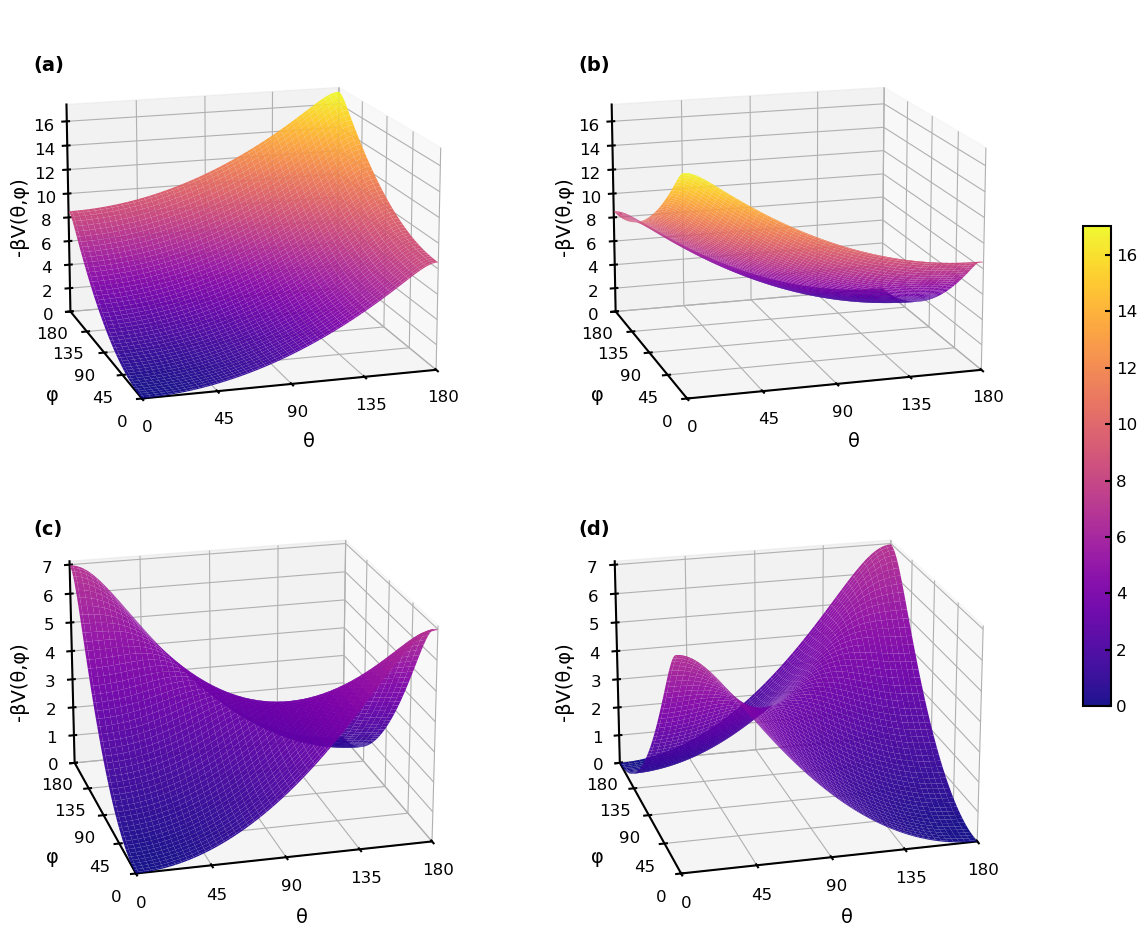

In [120]:
# Create the grid of plots with custom angles for each plot
fig = plot_energy_grid(
    final_coefficients,
    mode='energy',
    cmap='plasma',
    figsize=(14, 12),
    elev=[15, 15, 20, 20],  # Different for each plot
    azim=[73, 73, 75, 75], # Different for each plot
    save_path=None  # Set a path if you want to save the figure
)

plt.show()

In [122]:
fig.savefig(f"energy3D_all.png", bbox_inches='tight', dpi=200)
fig.savefig(f"energy3D_all.eps", bbox_inches='tight', dpi=200)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
